# Task 2 extra: Clustering

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Loading the Customer Profile model

In [30]:
extra_customer_profile = pd.read_csv('../dataset/extra_customer_profile_model.csv', sep='\t', index_col=0)
extra_customer_profile

,Savg,categ_-1,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,categ_10,categ_11,categ_12,categ_13,categ_14,categ_15
CustomerID,,,,,,,,,,,,,,,,,,
12347.0,599.701667,34.626662,0.763713,4.085365,1.462950,12.247757,14.858777,2.159407,1.547992,0.000000,0.767048,1.550771,8.037330,2.876430,3.518416,1.000497,9.146214,1.350672
12348.0,261.480000,52.608230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.323543,0.000000,0.000000,0.000000,42.068227,0.000000,0.000000,0.000000,0.000000,0.000000
12349.0,1457.550000,51.185894,0.000000,5.176495,3.980652,0.000000,4.497273,0.455559,12.785839,0.000000,0.000000,1.029124,1.365305,8.897122,4.472574,5.433776,0.720387,0.000000
12350.0,294.400000,44.565217,0.000000,0.000000,23.029891,0.000000,6.929348,0.000000,13.654891,0.000000,0.000000,0.000000,0.000000,0.000000,6.725543,5.095109,0.000000,0.000000
12352.0,210.901667,51.985522,0.000000,1.327633,4.512371,2.560435,8.167313,1.173533,3.056717,0.000000,0.924602,1.849203,1.173533,11.039900,0.000000,1.185387,5.626635,5.417217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,180.600000,38.842746,0.000000,0.000000,0.000000,16.611296,0.000000,0.000000,0.000000,0.000000,0.000000,21.594684,0.000000,0.000000,0.000000,9.883721,0.000000,13.067553
18281.0,80.820000,41.945063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.930958,0.000000,0.000000,0.000000,0.000000,0.000000,39.123979
18282.0,88.300000,21.002265,0.000000,7.644394,7.061155,0.000000,41.223103,0.000000,0.000000,0.000000,12.995470,0.000000,7.219706,0.000000,0.000000,0.000000,0.000000,2.853907


## Standardization \& Dimensionality Reduction

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

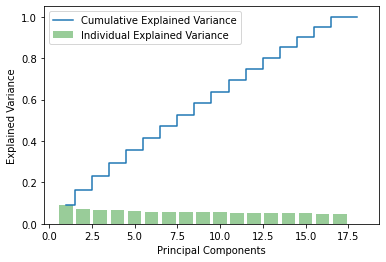

In [32]:
scaler = StandardScaler()
std_extra_customer_profile = scaler.fit_transform(extra_customer_profile)

pca = PCA()
pca.fit(std_extra_customer_profile)

plt.step(range(1, extra_customer_profile.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), 
         where='mid', label='Cumulative Explained Variance')
plt.bar(range(1, extra_customer_profile.shape[1] + 1), pca.explained_variance_ratio_, 
        alpha=0.4, color='g', label='Individual Explained Variance')

plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.legend(loc='upper left');

The graph shows the amount of variance captured depending on the number of components we include. A rule of thumb is to preserve around 80% of the variance. So, in this instance, we decide to keep 2 components.

In [33]:
pca = PCA(n_components=13)
pca_extra_customer_profile = pca.fit_transform(std_extra_customer_profile)

## Data Visualization


t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

It is highly recommended to use another dimensionality reduction method (e.g., PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.

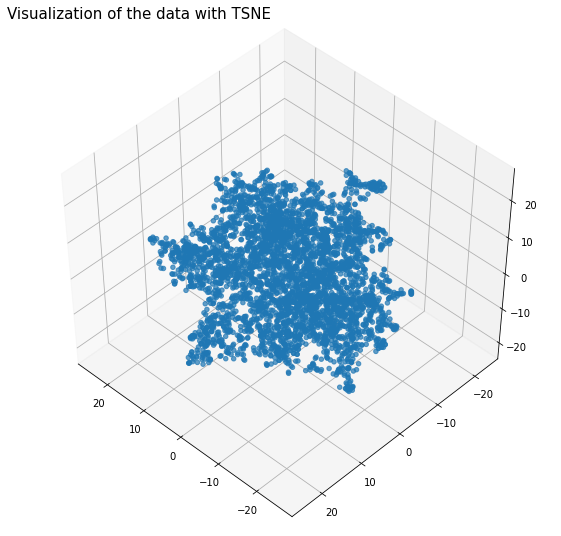

In [63]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, n_jobs=-1)
tsne_extra_customer_profile = tsne.fit_transform(pca_extra_customer_profile)
fig = plt.figure(1, figsize=(8,7))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(*tsne_extra_customer_profile.T, s=20, alpha=0.7)
ax.set_title('Visualization of the data with TSNE', loc='left', fontsize=15);

## K-Means

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [36]:
elbow = []
silhouette = []
for k in range(2, 15):
    kmeans = KMeans(init='k-means++', n_clusters=k)
    clusters = kmeans.fit_predict(pca_extra_customer_profile)
    elbow.append(kmeans.inertia_)
    silhouette.append(silhouette_score(pca_extra_customer_profile, clusters))

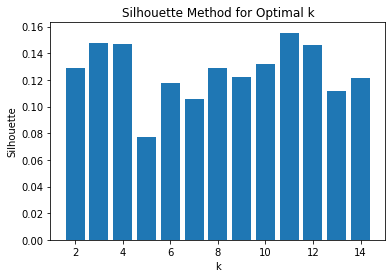

In [37]:
plt.bar(range(2, 15), silhouette)
plt.title('Silhouette Method for Optimal k')
plt.ylabel('Silhouette')
plt.xlabel('k');

In [38]:
print('The best silhouette score is:', max(silhouette))

The best silhouette score is: 0.15544574402122968


In [40]:
kmeans = KMeans(init='k-means++', n_clusters=3)
clusters_customers = kmeans.fit_predict(pca_extra_customer_profile)

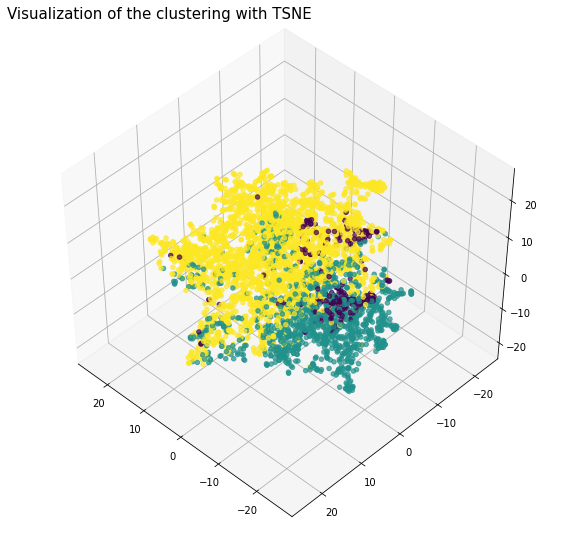

In [66]:
# create a scatter plot
fig = plt.figure(1, figsize=(8,7))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(*tsne_extra_customer_profile.T, c=clusters_customers, s=20, alpha=0.7)
ax.set_title('Visualization of the clustering with TSNE', loc='left', fontsize=15);

In [42]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T.sort_index(axis=1)

,0,1,2
CustomersNb,278,1259,2669


In [43]:
extra_customer_profile_kmeans = extra_customer_profile.copy(deep=True)
extra_customer_profile_kmeans['cluster'] = clusters_customers
extra_customer_profile_kmeans

,Savg,categ_-1,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,categ_10,categ_11,categ_12,categ_13,categ_14,categ_15,cluster
CustomerID,,,,,,,,,,,,,,,,,,,
12347.0,599.701667,34.626662,0.763713,4.085365,1.462950,12.247757,14.858777,2.159407,1.547992,0.000000,0.767048,1.550771,8.037330,2.876430,3.518416,1.000497,9.146214,1.350672,2
12348.0,261.480000,52.608230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.323543,0.000000,0.000000,0.000000,42.068227,0.000000,0.000000,0.000000,0.000000,0.000000,2
12349.0,1457.550000,51.185894,0.000000,5.176495,3.980652,0.000000,4.497273,0.455559,12.785839,0.000000,0.000000,1.029124,1.365305,8.897122,4.472574,5.433776,0.720387,0.000000,2
12350.0,294.400000,44.565217,0.000000,0.000000,23.029891,0.000000,6.929348,0.000000,13.654891,0.000000,0.000000,0.000000,0.000000,0.000000,6.725543,5.095109,0.000000,0.000000,2
12352.0,210.901667,51.985522,0.000000,1.327633,4.512371,2.560435,8.167313,1.173533,3.056717,0.000000,0.924602,1.849203,1.173533,11.039900,0.000000,1.185387,5.626635,5.417217,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,180.600000,38.842746,0.000000,0.000000,0.000000,16.611296,0.000000,0.000000,0.000000,0.000000,0.000000,21.594684,0.000000,0.000000,0.000000,9.883721,0.000000,13.067553,2
18281.0,80.820000,41.945063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.930958,0.000000,0.000000,0.000000,0.000000,0.000000,39.123979,2
18282.0,88.300000,21.002265,0.000000,7.644394,7.061155,0.000000,41.223103,0.000000,0.000000,0.000000,12.995470,0.000000,7.219706,0.000000,0.000000,0.000000,0.000000,2.853907,0


In [44]:
extra_customer_profile_kmeans.to_csv('../dataset/extra_customer_profile_kmeans.csv', sep='\t')